In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import keras
from keras import models, layers
import tensorflow as tf

In [73]:
IMAGE_SIZE = 256 
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [74]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "dataset_PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [75]:
class_names = dataset.class_names # list of class names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [76]:
len(dataset) # number of batches

68

In [77]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 2 1 1 1 1 1 0 0 0 1 0 1 2 1 1]


2025-11-26 23:29:12.321715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-11-26 23:29:12.881039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


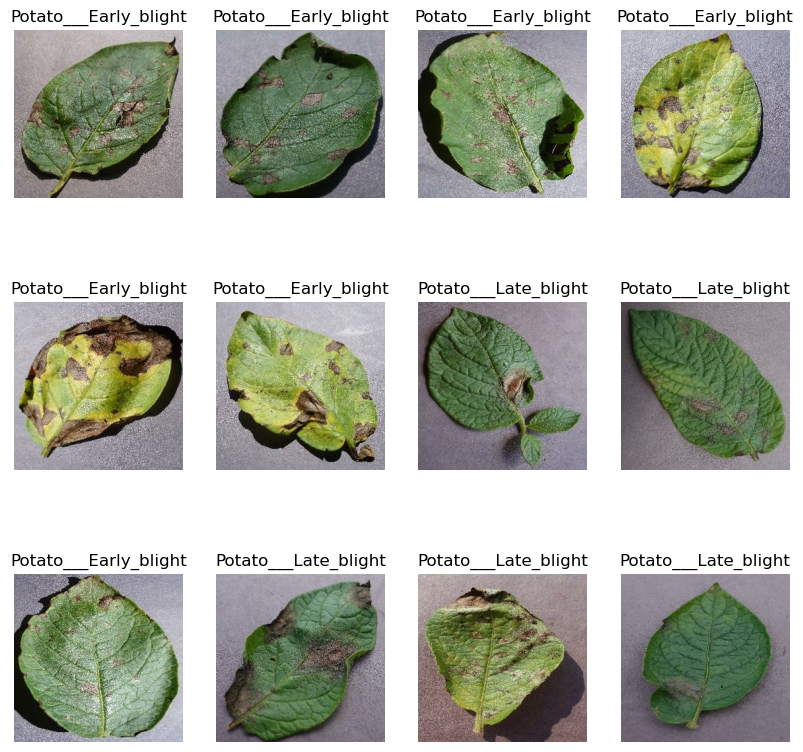

In [78]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [79]:
train_size = 0.8

In [80]:
train_dataset = dataset.take(int(len(dataset) * train_size))
validation_dataset = dataset.skip(int(len(dataset) * train_size))
test_dataset = validation_dataset.skip(int(len(validation_dataset) * 0.5))
print(len(train_dataset), len(validation_dataset), len(test_dataset))

54 14 7


In [81]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=0)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [82]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [83]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [84]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [85]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [86]:



# Preprocessing: declare input_shape on the first preprocessing layer
resize_and_rescale = keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Rescaling(1./255)
], name="resize_and_rescale")

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
], name="data_augmentation")

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu'),   # no input_shape here
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


model.summary()


/opt/miniconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resize_and_rescale (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 127, 127, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 62, 62, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (None, 14, 14, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (None, 6, 6, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 2, 2, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [88]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,verbose=1,batch_size=BATCH_SIZE)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.4812 - loss: 0.9382 - val_accuracy: 0.6042 - val_loss: 0.7562
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.6823 - loss: 0.7205 - val_accuracy: 0.8542 - val_loss: 0.4146
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8134 - loss: 0.4486 - val_accuracy: 0.8698 - val_loss: 0.3556
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8457 - loss: 0.3849 - val_accuracy: 0.8958 - val_loss: 0.2806
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8751 - loss: 0.3110 - val_accuracy: 0.9323 - val_loss: 0.1767
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8921 - loss: 0.2496 - val_accuracy: 0.9583 - val_loss: 0.1353
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9285 - loss: 0.2008 - val_accuracy: 0.9062 - val_loss: 0.1936
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9178 - loss: 0.1953 - val_accuracy: 0.9323 - v

In [89]:
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 468ms/step - accuracy: 0.9737 - loss: 0.0938
Test Loss: 0.13353532552719116
Test Accuracy: 0.9482758641242981


First image to predict:
True label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
Predicted label: Potato___healthy


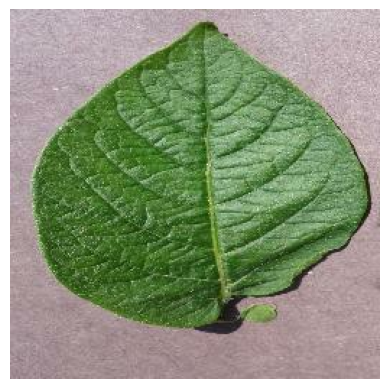

2025-11-27 00:05:13.299146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [90]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    plt.axis("off")
    
    print(f"True label: {class_names[first_label]}")

    batch_prediction = model.predict(image_batch)
    print(f"Predicted label: {class_names[np.argmax(batch_prediction[0])]}")
    plt.show()

In [93]:
def predict(model,img):
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(predictions[0])
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2025-11-27 00:07:02.107760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


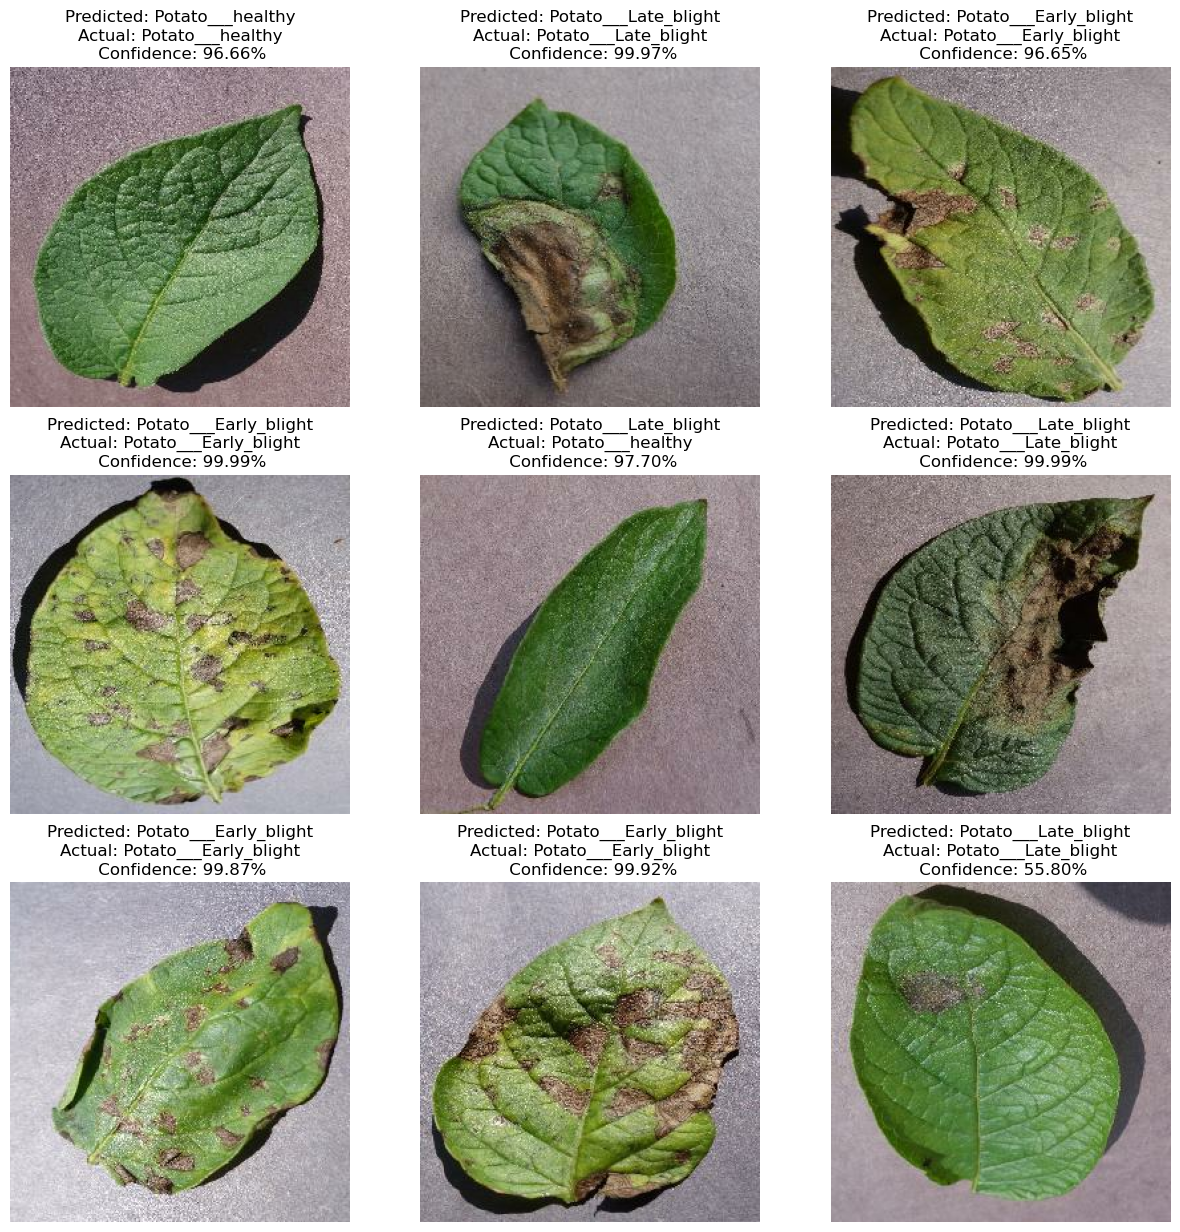

In [97]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]]
        plt.title(f"Predicted: {predicted_class}\nActual: {actual_class}\n Confidence: {confidence:.2f}%")

        plt.axis("off")